In [1]:
# !pip3 install sktime pmdarima

In [2]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
# import fcn_helpers as fhelp
# import fcn_simulation as fsim
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import MeanAbsoluteError

import carlos_utils.file_utils as fu

#plt.rcParams['figure.figsize'] = [14, 7]
# fhelp.makeFolder('results')
pd.options.display.max_rows = None
# Use v2.0 colour cycle
def_colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Fig sizes
fig_h = 10
fig_w = 18

/usr/local/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [3]:
import sktime
sktime.__version__

'0.11.2'

In [4]:
folder = '/Users/carlos.aguilar/Documents/EF_Finance/data'
filename = 'aggregated_teach_online.pickle'
filepath = fu.fullfile(folder, filename)
df_aggregated  = fu.readPickleFile(filepath)

In [38]:
this_country = 'Brazil'
this_service = 'CP20'
# this_service = 'EFTV'
# this_service = 'Writing'
# this_service = 'GL'

idx_country = df_aggregated.region_name == this_country
df_aggregated_country = df_aggregated[idx_country]
df_service = df_aggregated_country[df_aggregated_country.service==this_service]
df_service.sort_values(by=['product_line','product_category', 'completed_date'], inplace=True)

min_samples = 10
temp_valid_categories = df_service.product_category.value_counts() > min_samples
valid_categories = temp_valid_categories.index[temp_valid_categories.values].tolist()



/var/folders/d4/dxr4y6295wg7lvsw32g7hq8h0000gn/T/ipykernel_95443/3520387243.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_service.sort_values(by=['product_line','product_category', 'completed_date'], inplace=True)


In [69]:
this_category = valid_categories[0]
df_to_frc = df_service[df_service.product_category == this_category].reset_index(drop=True)

In [70]:
test_date = datetime.date(2022, 1, 1)
idx_test = df_to_frc.completed_date > test_date
df_train = df_to_frc[~idx_test].copy()
df_test = df_to_frc[idx_test].copy()


#

y_train = df_train.total_usage
y_test  = df_test.total_usage

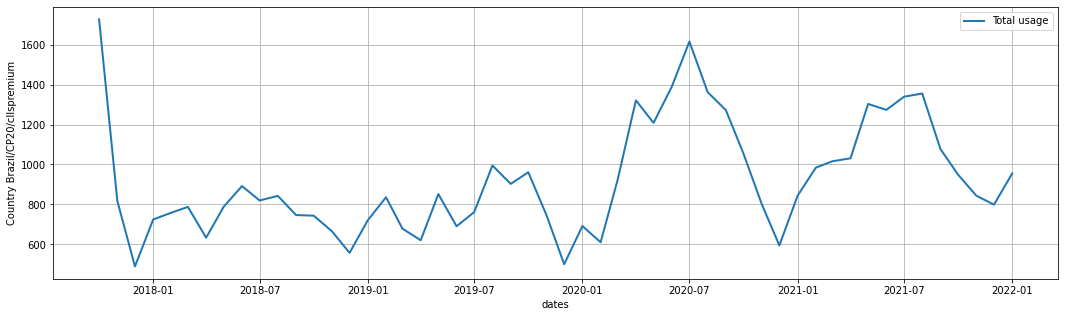

In [71]:
fig_title = f'Country {this_country}/{this_service}/{this_category}'
x_axis = df_train.completed_date
y_axis = df_train.total_usage
f, ax = plt.subplots(figsize=(fig_w, fig_h/2))
ax.plot(x_axis, y_axis, label='Total usage', color=def_colours[0], linewidth=2)
#ax.plot(x_axis,df_regular.sum(axis=1), label='Regular sales')
plt.xlabel('dates')
plt.ylabel(fig_title)
plt.grid(True)
plt.legend()
plt.show()

In [72]:
df_to_frc.tail()

,product_line,product_category,region_name,service,completed_date,total_usage
49,LLS,cllspremium,Brazil,CP20,2021-11-01,844.0
50,LLS,cllspremium,Brazil,CP20,2021-12-01,799.0
51,LLS,cllspremium,Brazil,CP20,2022-01-01,955.0
52,LLS,cllspremium,Brazil,CP20,2022-02-01,1025.0
53,LLS,cllspremium,Brazil,CP20,2022-03-01,1089.0


In [73]:
# rmsse = MeanSquaredScaledError(square_root=True)
mae = MeanAbsoluteError()

# Naive forecast

In [74]:
reg_period = 3
fh = np.arange(len(y_test)) + 1
from sktime.forecasting.naive import NaiveForecaster
forecaster = NaiveForecaster(strategy="mean", sp=reg_period)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
# plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mae(y_pred, y_test)

163.85294117647055

# Holt-Winters

7.477158771882046

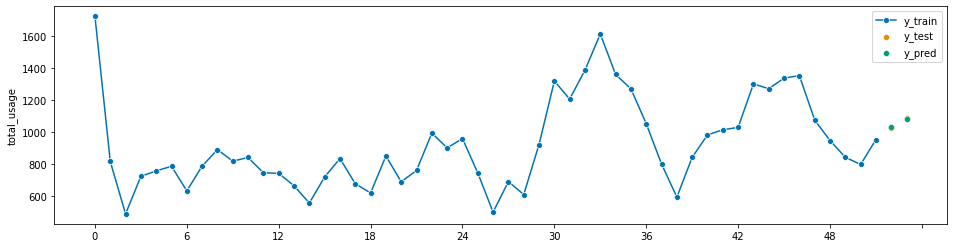

In [80]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

reg_period = 12
forecaster = ExponentialSmoothing(trend="add", seasonal="multiplicative", sp=reg_period)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
y_pred, y_test
mae(y_pred, y_test)